# Credit Card Approval

## Import packages

In [1]:
import Algorithmia
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from joblib import dump
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
ALGORITHMIA_API_KEY = os.getenv("ALGORITHMIA_API_KEY", None)
ALGORITHMIA_API = os.getenv("ALGORITHMIA_API", None)
client = Algorithmia.client(ALGORITHMIA_API_KEY, ALGORITHMIA_API)

## Load data

In [7]:
data = pd.read_parquet(client.file("data://algorithmia_se/CreditCardApproval/clean-data.parquet").getFile().name)

RuntimeError: Decompression 'SNAPPY' not available.  Options: ['GZIP', 'UNCOMPRESSED']

## Balance data

In [4]:
data.columns.values[0] = "high_balance"
X = data.iloc[:,:-1]
Y = data.iloc[:,-1:]
Y = Y.astype('int')

In [5]:
X_balance,Y_balance = SMOTE().fit_sample(X, Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

## Split the data into training and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,
                                                    Y_balance, 
                                                    stratify=Y_balance,
                                                    test_size=0.3,
                                                    random_state=123)

## Load and train gradient boosting model

In [7]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier()

## Generate predictions on test data

In [8]:
pred = model.predict(X_test)

## Show fraction of at-risk customers

In [9]:
round(sum(pred) / len(pred), 2)

0.5

## Calculate model accuracy

In [10]:
model.score(X_test, y_test)
print('Accuracy score is', round(accuracy_score(y_test, pred), 2))

Accuracy score is 0.79


## Classification report

In [11]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      7414
           1       0.80      0.79      0.79      7414

    accuracy                           0.79     14828
   macro avg       0.79      0.79      0.79     14828
weighted avg       0.79      0.79      0.79     14828



## Test predictions

### Approved credit card

In [12]:
sample_data = np.array([[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])
sample_pred = model.predict_proba(sample_data)
print("Risk score:", round(sample_pred[0][1], 2))
print("Approved:", 1 - model.predict(sample_data)[0])  # 1 = approved, 0 = denied

Risk score: 0.08
Approved: 1


### Denied credit card

In [13]:
sample_data = np.array([[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
sample_pred = model.predict_proba(sample_data)
print("Risk score:", round(sample_pred[0][1], 2))
print("Approved:", 1 - model.predict(sample_data)[0])  # 1 = approved, 0 = denied

Risk score: 0.72
Approved: 0


## Confusion matrix

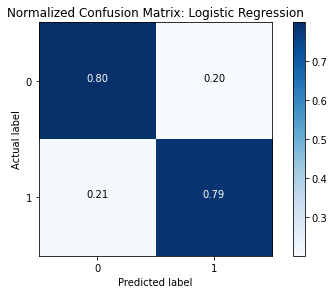

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test, pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

## Feature importance

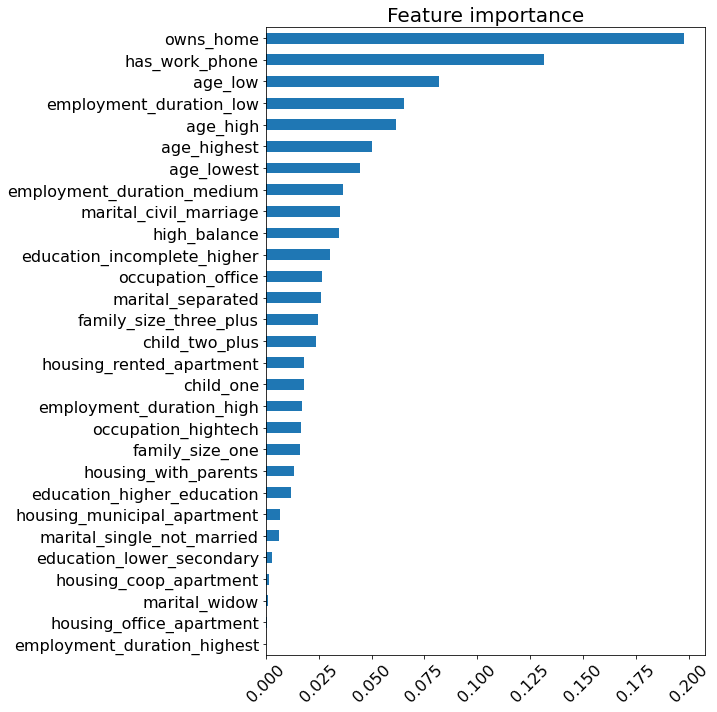

In [15]:
importance = pd.DataFrame(model.feature_importances_)
importance.index = X.columns
importance = importance.sort_values(0)
plot = importance.plot.barh(title="Feature importance", fontsize=16, legend=False, figsize=(10, 10))
plot.axes.title.set_size(20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/features-a.png")

## Save model

In [16]:
dump(model, "model/model-a.joblib")

['model/model-a.joblib']

## Upload model

In [17]:
client.file("data://AlgorithmiaSE/CreditCardApproval/model-a.joblib").putFile("model/model-a.joblib")

## Upload image

In [18]:
client.file("data://AlgorithmiaSE/CreditCardApproval/features-a.png").putFile("images/features-a.png")